# Final Project Dataset - Yelp
<img src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Yelp_Logo.svg" style="float:  left; margin: 20px; height: 70px">

## Project Overview

For this project, we will predict the stars on Yelp based business attributes and reviews from customers. The dataset that we will be using has been directly downloaded from Kaggle, which is subset of Yelp's businesses, reviews, and user data transformed into a CSV format. The orginal dataset is freely available in JSON or SQL format on https://www.yelp.com/dataset. In the dataset you'll find information about businesses across 11 metropolitan areas in four countries including more than 170,000 business and 5.2 million reviews.


## Table of Contents:
1. [Introduction](#intro)  
    1.1 [Yelp Dataset](#yelpdata)   
    1.2 [Data Dictionary](#datadictionary)   
2. [Data Cleaning](#cleaning)  
    2.1 [Adding Number of Tips](#tips)  
    2.2 [Open during Weekend](#weekend)  
    2.3 [Adding Categories](#addcategories)   
    2.4 [Tip NLP - Sentiment Analysis](#tip_sentiment)  
    2.5 [Reviews NLP - Sentiment Analysis](#reviews_sentiment)   
    2.6 [Target](#target)  
    2.7 [Cleanup of NaN Values](#nancleanup)   
    2.8 [Cleanup of the Data before Modeling](#lastcleanup)    
3. [EDA](#eda)  
    3.1 [Analysis on the variable 'Stars'](#edastars)   
    3.2 [Analysis on the different Categories](#edacategory)    
    3.3 [Correlation Analysis](#correlation)  
    3.4 [Summary Statistics](#edastatistics)   
4. [Models](#models)   
    4.1 [All Classic Models](#classic_models)   
    4.2 [Complex Models with Lasso & GridSearch](#complex_models)     
    4.3 [Predictions with Best Model](#prediction)   
    4.4 [Confusion Matrix](#confusion)  
5. [Conclusions](#conclusions)  
    
    

In [81]:
# import all packages
import numpy as np
import pandas as pd
import numba.cuda
from numba import jit
import cython
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from itertools import combinations
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')
# Will display all rows
pd.set_option('display.max_columns', 500)


<a id="intro"></a>
# 1. Introduction
---
The overall idea would be to predict the stars rating on Yelp for each business, this will be our target. The stars are reported by each users in the range of 1 to 5. For our project, we will rate a business as "GOOD" or "BAD", and to do so we categorize the stars ratings between a range of 1-3 and 4-5 for "BAD", and "GOOD", respectively. 

We will firstly focus on our dataset and add more variables, such specific categories, open during week, tips and review sentiment analysis. We will then review the EDA and run the various classic models. Depending on the results from the classic model, we will develop a more complex model with estimation for different parameters. 


### Model that we will be using
- Logistic Regression
- KNN
- Decision Tree
- Random Forest


<a id="yelpdata"></a>
## 1.1 Yelp Dataset
---
The data can be downloaded directly from Yelp and can downloaded in .csv format from Kaggle. We will be using a total of 5 files:
- yelp_business.csv: this contains all the stars of the business and its metadata, such as; id, name, postcode, latitude, review count and categories.
- yelp_business_attributes.csv: contains more attributes from each business, such as Dogs allowed, Wifi available, etc..
- yelp_tips: which contains all the tips, which are like reviews but they are short and normally contains a tip from customers. 
- yelp_business_hours: which contains the opening hours of each business.
- yelp_reviews: contains all 5 millions reviews for each user

<a id="datadictionary"></a>
## 1.2 Data Dictionary
---
Below the data dictionary with all information for each columns in our both yelp_business and yelp_business attributes:



**For yelp_business.csv**:


Column Name|Type|Description
---------|----|-----------
business_id|string|22 character unique business ID
name|string|the business's name
neighborhood|string|the neighborhood's name
address|string|the full address of the business
city|string| the city
state|string| 2 character state code, if applicable
postal_code|string| the postal code
latitude|float| latitude
longitude|float| longitude
stars|float| star rating, rounded to half-stars
review_count|integer| number of reviews
is_open|integer| business open or not
categories|string|categories for the business, separated by ';'


**For yelp_business_attributes.csv** (Only the columns that we will be using, as it has a total of 82 columns):


|      Column Name                      |   Type    |        Description          | 
|----------------------------|-------|------------------| 
| business_id                | string|22 character unique business ID
| BusinessAcceptsCreditCards | float | True, False, NaN | 
| BusinessParking_garage     | float | True, False, NaN | 
| BusinessParking_street     | float | True, False, NaN | 
| BusinessParking_validated  | float | True, False, NaN | 
| BusinessParking_lot        | float | True, False, NaN | 
| BusinessParking_valet      | float | True, False, NaN | 
| HairSpecializesIn_coloring | float | True, False, NaN | 
| WheelchairAccessible       | float | True, False, NaN | 
| BikeParking                | float | True, False, NaN | 
| Alcohol                    | float | True, False, NaN | 
| HappyHour                  | float | True, False, NaN | 
| DogsAllowed                | float | True, False, NaN | 


**from other files such as yelp_tips, yelp_reviews, yelp_business_hours:**


|      Column Name                      |   Type    |        Description          | 
|----------------------------|-------|------------------| 
| business_id                | string|22 character unique business ID
| weekday                     | string | Monday to Friday open | 
| review_id               | string | 22 character unique review id | 
| text               | string | the review or tip itself | 
| useful                     | integer |number of useful votes received | 
| funny               | integer | number of funny votes received| 
| cool               | integer |number of cool votes received | 



<a id="cleaning"></a>
# 2. Data Cleaning
---
We will first open 'business', 'business_att' and 'user'. Under the business attribute file, we have lots of NaN which we are indicating with na_values.

In [82]:
business = pd.read_csv('yelp-dataset/yelp_business.csv')
business_att = pd.read_csv('yelp-dataset/yelp_business_attributes.csv', na_values= 'Na', low_memory=False)

Let's first merge both files (buiness and business attribute) to get all info into one file. We are filtering all with the buiness ID column.

In [83]:
all_business = pd.merge(left=business,right=business_att, how='left',left_on='business_id', right_on='business_id')
print(business.shape)
print(business_att.shape)
print(all_business.shape)

(174567, 13)
(152041, 82)
(174567, 94)


We will now eliminate the businesses that are closed and also eliminate the columns that has a large number of NaN with a threshold of 5000, meaning that we keep columns that have at least 5000 non-null object.

In [84]:
all_business = all_business[all_business["is_open"] == 1]
all_business = all_business.dropna(axis=1,thresh=5000)

print(all_business.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146702 entries, 0 to 174566
Data columns (total 25 columns):
business_id                   146702 non-null object
name                          146702 non-null object
neighborhood                  55518 non-null object
address                       146702 non-null object
city                          146701 non-null object
state                         146701 non-null object
postal_code                   146122 non-null object
latitude                      146702 non-null float64
longitude                     146702 non-null float64
stars                         146702 non-null float64
review_count                  146702 non-null int64
is_open                       146702 non-null int64
categories                    146702 non-null object
BusinessAcceptsCreditCards    21449 non-null object
BusinessParking_garage        19365 non-null object
BusinessParking_street        29075 non-null object
BusinessParking_validated     29075 non-null

<a id="tips"></a>
## 2.1 Adding Number of Tips
---
We will be adding now the number of tips for each buinesses. Tips are similar than reviews but they are short and normally contains a tip from customers, something like "Buy one get one free today!". All these tips comments are located in the file called 'yelp-tip.csv'. We will simply sum all the reviews for each business in a list and merge it to a new column in our database. We should now have a total of 26 columns in our dataset.

In [85]:
tips = pd.read_csv('yelp-dataset/yelp_tip.csv')

In [86]:
tips.shape

(1098324, 5)

In [87]:
tips_by_business = list(tips.business_id)

tip_counts = defaultdict(int)
for bus in tips_by_business:
    tip_counts[bus] += 1

In [88]:
# put all in a dataframe table
table = [(k, v) for (k, v) in tip_counts.items()]
tips_total = pd.DataFrame(table)
tips_total.columns = ["business_id", "tip_count"]
tips_total.head()

,business_id,tip_count
0,jH19V2I9fIslnNhDzPmdkA,1
1,dAa0hB2yrnHzVmsCkN4YvQ,2
2,ESzO3Av0b1_TzKOiqzbQYQ,74
3,k7WRPbDd7rztjHcGGkEjlw,11
4,SqW3igh1_Png336VIb5DUA,3


In [89]:
#merge all into our dataset
all_business = pd.merge(left=all_business ,right=tips_total, how='left', left_on='business_id', right_on='business_id')
print(all_business.shape)

(146702, 26)


In [90]:
#put 0 if NaN and back to integer 
all_business['tip_count'].fillna(0, inplace=True)
all_business['tip_count'] = all_business['tip_count'].astype(np.int64)

In [91]:
#check for tip and review count
all_business.loc[[3],['business_id','tip_count','review_count']]

,business_id,tip_count,review_count
3,PfOCPjBrlQAnz__NXj9h_w,17,116


<a id="weekend"></a>
## 2.2 Open during Weekend
---
We will now add a variable to indicate if the business is open during weekend or not. This information can be found under the file called "yelp_business_hours.csv". We calculate if the business is open on Saturday and Sunday and it will return True or False. We can then merge all with our main dataset called "all_business".

In [92]:
business_hours = pd.read_csv('yelp-dataset/yelp_business_hours.csv')

In [93]:
business_hours['weekendopen'] = (business_hours['saturday'] != "None") & (business_hours['sunday'] != "None")
weekendopen = pd.DataFrame(business_hours, columns=['business_id','weekendopen'])

#merge all into our dataset
all_business = pd.merge(left=all_business ,right=weekendopen, how='left', left_on='business_id', right_on='business_id')
print(all_business.shape)

(146702, 27)


In [94]:
# all into dummy - true ==False
all_business['weekendopen'] = np.where(all_business['weekendopen'] == True ,1, 0)

<a id="addcategories"></a>
## 2.3 Adding Categories
---
We will now add all categories into each columns.

In [95]:
# if the category is in mutiple business then take it, we set threashold of 1000 here, meaning that hte category should appear at least 1000 times in Data

threshold = 1000 
list_of_cat = [row.split(';') for row in all_business['categories']]
list_of_cat[:10]
distinct_cat = set(x for l in list_of_cat for x in l)
del_col = []  # the list of col to delete after
for cat in distinct_cat:
    all_business['categories' + cat] = all_business['categories'].map(lambda val: 1 if cat in val else 0)
    if sum(all_business['categories' + cat]==1) < threshold:
        del_col.append('categories' + cat)
# drop col no needed
all_business = all_business.drop(del_col, axis=1)
business_category=' '.join(all_business['categories'])
all_business = all_business.drop('categories', axis=1)
all_business.shape

(146702, 146)

In [96]:
all_business.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,BusinessAcceptsCreditCards,BusinessParking_garage,BusinessParking_street,BusinessParking_validated,BusinessParking_lot,BusinessParking_valet,HairSpecializesIn_coloring,WheelchairAccessible,BikeParking,Alcohol,HappyHour,DogsAllowed,tip_count,weekendopen,categoriesAutomotive,categoriesCaterers,categoriesGeneral Dentistry,categoriesAppliances,categoriesPets,categoriesDesserts,categoriesSpecialty Food,categoriesWomen's Clothing,categoriesBanks & Credit Unions,categoriesGyms,categoriesPet Groomers,categoriesHome & Garden,categoriesFlowers,categoriesDoctors,categoriesDepartment Stores,categoriesDrugstores,categoriesShoe Stores,categoriesArts & Crafts,categoriesPizza,categoriesMassage,categoriesTires,categoriesWine & Spirits,categoriesAuto Parts & Supplies,categoriesPet Services,categoriesBurgers,categoriesItalian,categoriesPet Sitting,categoriesSpecialty Schools,categoriesCanadian (New),categoriesIT Services & Computer Repair,categoriesBreakfast & Brunch,categoriesSkin Care,categoriesNail Salons,categoriesCoffee & Tea,categoriesBakeries,categoriesMediterranean,categoriesSushi Bars,categoriesApartments,categoriesSteakhouses,categoriesAmerican (New),categoriesMassage Therapy,categoriesSandwiches,categoriesOptometrists,categoriesGas Stations,categoriesSporting Goods,categoriesChiropractors,categoriesDay Spas,categoriesConvenience Stores,categoriesNightlife,categoriesHair Salons,categoriesParks,categoriesCar Dealers,categoriesJewelry,categoriesJuice Bars & Smoothies,categoriesAsian Fusion,categoriesCafes,categoriesBars,categoriesLaundry Services,categoriesFood,categoriesFast Food,categoriesPlumbing,categoriesHotels,categoriesSeafood,categoriesBarbeque,categoriesRestaurants,categoriesPublic Services & Government,categoriesChinese,categoriesWaxing,categoriesAccessories,categoriesBarbers,categoriesContractors,categoriesVenues & Event Spaces,categoriesBeer,categoriesLocal Services,categoriesHair Removal,categoriesVeterinarians,categoriesIce Cream & Frozen Yogurt,categoriesFashion,categoriesCosmetics & Beauty Supply,categoriesHome Decor,categoriesGrocery,categoriesMexican,categoriesEvent Planning & Services,categoriesSports Bars,categoriesHealth & Medical,categoriesReal Estate Services,categoriesHeating & Air Conditioning/HVAC,categoriesHotels & Travel,categoriesActive Life,categoriesShopping,categoriesBeauty & Spas,categoriesFitness & Instruction,categoriesProfessional Services,categoriesChicken Wings,categoriesArts & Entertainment,categoriesFlowers & Gifts,categoriesEyelash Service,categoriesEducation,categoriesSalad,categoriesDry Cleaning,categoriesHair Stylists,categoriesParty & Event Planning,categoriesDentists,categoriesHome Services,categoriesFurniture Stores,categoriesNa,categoriesElectronics,categoriesTrainers,categoriesFinancial Services,categoriesAmerican (Traditional),categoriesReal Estate,categoriesJapanese,categoriesOil Change Stations,categoriesCosmetic Dentists,categoriesDry Cleaning & Laundry,categoriesDelis,categoriesAuto Repair,categoriesPubs,categoriesMedical Centers,categoriesMen's Clothing
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

<a id="tip_sentiment"></a>
## 2.4 Tip NLP - Sentiment Analysis
---
Let's now use a sentiment analysis with the reviews and tips submitted for each businesses by users. Firstly, we will analyse the text submitted for tip (around 1 million Tips) and then the actual 5 million reviews in the next section. We will be using the package nltk with SentimentIntensityAnalyzer. This will analyse each text and provides a sentiment between 0 to 1 for Negative,  Positive, Neutral impression. The Compound is simply an average of all three sentiments. 

In [97]:
#import package for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.downloader.download('vader_lexicon')
from tqdm import tqdm
import sys

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lucienrey/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [98]:
tip = pd.read_csv('yelp-dataset/yelp_tip.csv')

In [99]:
def print_sentiment_scores(sentence):
    analyser = SentimentIntensityAnalyzer()
    snt = analyser.polarity_scores(sentence)

In [100]:
#make sure the column 'text' is set as a string format
tip_new = tip
tip_new['text'] = tip_new['text'].astype(str)

In [101]:
# run the code and save the sentiment in results = []
results = []
analyser = SentimentIntensityAnalyzer()
for i in tqdm(tip_new['text']):
    snt = analyser.polarity_scores(i)
    results.append(snt)

100%|██████████| 1098324/1098324 [03:25<00:00, 5340.13it/s]


In [102]:
results_sentiment = pd.DataFrame(results)
tip_sentiment = pd.concat([tip_new,results_sentiment], axis=1)

In [103]:
# delete unecessary columns
tip_sentiment = tip_sentiment.drop(['user_id', 'date', 'text'], axis=1)

In [104]:
#renaming columns for consistency
tip_sentiment = tip_sentiment.rename(index=str, columns={"neg": "neg_tip", 
                                             "neu": "neu_tip", 
                                             "pos": "pos_tip", 
                                             "compound": "comp_tip"})
tip_sentiment.head(1)

,likes,business_id,comp_tip,neg_tip,neu_tip,pos_tip
0,0,jH19V2I9fIslnNhDzPmdkA,0.8777,0.0,0.41,0.59


In [105]:
# group and merge to dataset 
neg_tip = tip_sentiment.groupby(['business_id'], as_index=False)[['neg_tip']].median()
neu_tip = tip_sentiment.groupby(['business_id'], as_index=False)[['neu_tip']].median()
pos_tip = tip_sentiment.groupby(['business_id'], as_index=False)[['pos_tip']].median()
comp_tip = tip_sentiment.groupby(['business_id'], as_index=False)[['comp_tip']].median()

In [106]:
#merge all into our dataset
all_business = pd.merge(left=all_business ,right=neg_tip, how='left', left_on='business_id', right_on='business_id')
all_business = pd.merge(left=all_business ,right=neu_tip, how='left', left_on='business_id', right_on='business_id')
all_business = pd.merge(left=all_business ,right=pos_tip, how='left', left_on='business_id', right_on='business_id')
all_business = pd.merge(left=all_business ,right=comp_tip, how='left', left_on='business_id', right_on='business_id')
print(all_business.shape)

(146702, 150)


In [107]:
all_business.head(2)

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,BusinessAcceptsCreditCards,BusinessParking_garage,BusinessParking_street,BusinessParking_validated,BusinessParking_lot,BusinessParking_valet,HairSpecializesIn_coloring,WheelchairAccessible,BikeParking,Alcohol,HappyHour,DogsAllowed,tip_count,weekendopen,categoriesAutomotive,categoriesCaterers,categoriesGeneral Dentistry,categoriesAppliances,categoriesPets,categoriesDesserts,categoriesSpecialty Food,categoriesWomen's Clothing,categoriesBanks & Credit Unions,categoriesGyms,categoriesPet Groomers,categoriesHome & Garden,categoriesFlowers,categoriesDoctors,categoriesDepartment Stores,categoriesDrugstores,categoriesShoe Stores,categoriesArts & Crafts,categoriesPizza,categoriesMassage,categoriesTires,categoriesWine & Spirits,categoriesAuto Parts & Supplies,categoriesPet Services,categoriesBurgers,categoriesItalian,categoriesPet Sitting,categoriesSpecialty Schools,categoriesCanadian (New),categoriesIT Services & Computer Repair,categoriesBreakfast & Brunch,categoriesSkin Care,categoriesNail Salons,categoriesCoffee & Tea,categoriesBakeries,categoriesMediterranean,categoriesSushi Bars,categoriesApartments,categoriesSteakhouses,categoriesAmerican (New),categoriesMassage Therapy,categoriesSandwiches,categoriesOptometrists,categoriesGas Stations,categoriesSporting Goods,categoriesChiropractors,categoriesDay Spas,categoriesConvenience Stores,categoriesNightlife,categoriesHair Salons,categoriesParks,categoriesCar Dealers,categoriesJewelry,categoriesJuice Bars & Smoothies,categoriesAsian Fusion,categoriesCafes,categoriesBars,categoriesLaundry Services,categoriesFood,categoriesFast Food,categoriesPlumbing,categoriesHotels,categoriesSeafood,categoriesBarbeque,categoriesRestaurants,categoriesPublic Services & Government,categoriesChinese,categoriesWaxing,categoriesAccessories,categoriesBarbers,categoriesContractors,categoriesVenues & Event Spaces,categoriesBeer,categoriesLocal Services,categoriesHair Removal,categoriesVeterinarians,categoriesIce Cream & Frozen Yogurt,categoriesFashion,categoriesCosmetics & Beauty Supply,categoriesHome Decor,categoriesGrocery,categoriesMexican,categoriesEvent Planning & Services,categoriesSports Bars,categoriesHealth & Medical,categoriesReal Estate Services,categoriesHeating & Air Conditioning/HVAC,categoriesHotels & Travel,categoriesActive Life,categoriesShopping,categoriesBeauty & Spas,categoriesFitness & Instruction,categoriesProfessional Services,categoriesChicken Wings,categoriesArts & Entertainment,categoriesFlowers & Gifts,categoriesEyelash Service,categoriesEducation,categoriesSalad,categoriesDry Cleaning,categoriesHair Stylists,categoriesParty & Event Planning,categoriesDentists,categoriesHome Services,categoriesFurniture Stores,categoriesNa,categoriesElectronics,categoriesTrainers,categoriesFinancial Services,categoriesAmerican (Traditional),categoriesReal Estate,categoriesJapanese,categoriesOil Change Stations,categoriesCosmetic Dentists,categoriesDry Cleaning & Laundry,categoriesDelis,categoriesAuto Repair,categoriesPubs,categoriesMedical Centers,categoriesMen's Clothing,neg_tip,neu_tip,pos_tip,comp_tip
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000,0.548,0.452,0.8134
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

<a id="reviews_sentiment"></a>
## 2.5 Reviews NLP - Sentiment Analysis
---
This section is exactly the same but for the reviews. The text analysis has been done in another file, as the process takes around 2 hours to analyze, but the script is exactly the same. Here, we have 5,000,000 reviews analyzed.

In [108]:
# import Review File, already processed by SentimentIntensityAnalyzer()
all_reviews = pd.read_csv('yelp-dataset/yelp_myreview_all_1.csv')

In [109]:
all_reviews.head()

,Unnamed: 0,review_id,business_id,stars,useful,funny,cool,compound,neg,neu,pos
0,0,vkVSCC7xljjrAI4UGfnKEQ,AEx2SYEUJmTxVVB18LlCwA,5.0,0.0,0.0,0.0,0.9551,0.000,0.645,0.355
1,1,n6QzIUObkYshz4dz2QRJTw,VR6GpWIda3SfvPC-lg9H3w,5.0,0.0,0.0,0.0,0.8167,0.000,0.907,0.093
2,2,MV3CcKScW05u5LVfF6ok0g,CKC0-MOWMqoeWf6s-szl8g,5.0,0.0,0.0,0.0,0.6249,0.000,0.925,0.075
3,3,IXvOzsEMYtiJI0CARmj77Q,ACFtxLv8pGrrxMm6EgjreA,4.0,0.0,0.0,0.0,0.8560,0.036,0.842,0.123
4,4,L_9BTb55X0GDtThi6GlZ6w,s2I_Ni76bjJNK9yG60iD-Q,4.0,0.0,0.0,0.0,0.8313,0.000,0.826,0.174


In [110]:
# delete non necessary columns
all_reviews = all_reviews.drop(['Unnamed: 0'], axis=1)

In [111]:
#renaming columns for consistency
all_reviews = all_reviews.rename(index=str, columns={"neg": "neg_review",
                                                     "neu": "neu_review", 
                                                     "pos": "pos_review", 
                                                     "compound": "comp_review"})
all_reviews.head(1)

,review_id,business_id,stars,useful,funny,cool,comp_review,neg_review,neu_review,pos_review
0,vkVSCC7xljjrAI4UGfnKEQ,AEx2SYEUJmTxVVB18LlCwA,5.0,0.0,0.0,0.0,0.9551,0.0,0.645,0.355


In [112]:
# groupby business_id for neg, neu, pos and we take the MEDIAN
neg = all_reviews.groupby(['business_id'], as_index=False)[['neg_review']].median()
neu = all_reviews.groupby(['business_id'], as_index=False)[['neu_review']].median()
pos = all_reviews.groupby(['business_id'], as_index=False)[['pos_review']].median()
comp = all_reviews.groupby(['business_id'], as_index=False)[['comp_review']].median()

In [113]:
#merge all into our dataset
all_business = pd.merge(left=all_business ,right=neg, how='left', left_on='business_id', right_on='business_id')
all_business = pd.merge(left=all_business ,right=neu, how='left', left_on='business_id', right_on='business_id')
all_business = pd.merge(left=all_business ,right=pos, how='left', left_on='business_id', right_on='business_id')
all_business = pd.merge(left=all_business ,right=comp, how='left', left_on='business_id', right_on='business_id')
print(all_business.shape)

(146702, 154)


In [114]:
all_business.head(2)

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,BusinessAcceptsCreditCards,BusinessParking_garage,BusinessParking_street,BusinessParking_validated,BusinessParking_lot,BusinessParking_valet,HairSpecializesIn_coloring,WheelchairAccessible,BikeParking,Alcohol,HappyHour,DogsAllowed,tip_count,weekendopen,categoriesAutomotive,categoriesCaterers,categoriesGeneral Dentistry,categoriesAppliances,categoriesPets,categoriesDesserts,categoriesSpecialty Food,categoriesWomen's Clothing,categoriesBanks & Credit Unions,categoriesGyms,categoriesPet Groomers,categoriesHome & Garden,categoriesFlowers,categoriesDoctors,categoriesDepartment Stores,categoriesDrugstores,categoriesShoe Stores,categoriesArts & Crafts,categoriesPizza,categoriesMassage,categoriesTires,categoriesWine & Spirits,categoriesAuto Parts & Supplies,categoriesPet Services,categoriesBurgers,categoriesItalian,categoriesPet Sitting,categoriesSpecialty Schools,categoriesCanadian (New),categoriesIT Services & Computer Repair,categoriesBreakfast & Brunch,categoriesSkin Care,categoriesNail Salons,categoriesCoffee & Tea,categoriesBakeries,categoriesMediterranean,categoriesSushi Bars,categoriesApartments,categoriesSteakhouses,categoriesAmerican (New),categoriesMassage Therapy,categoriesSandwiches,categoriesOptometrists,categoriesGas Stations,categoriesSporting Goods,categoriesChiropractors,categoriesDay Spas,categoriesConvenience Stores,categoriesNightlife,categoriesHair Salons,categoriesParks,categoriesCar Dealers,categoriesJewelry,categoriesJuice Bars & Smoothies,categoriesAsian Fusion,categoriesCafes,categoriesBars,categoriesLaundry Services,categoriesFood,categoriesFast Food,categoriesPlumbing,categoriesHotels,categoriesSeafood,categoriesBarbeque,categoriesRestaurants,categoriesPublic Services & Government,categoriesChinese,categoriesWaxing,categoriesAccessories,categoriesBarbers,categoriesContractors,categoriesVenues & Event Spaces,categoriesBeer,categoriesLocal Services,categoriesHair Removal,categoriesVeterinarians,categoriesIce Cream & Frozen Yogurt,categoriesFashion,categoriesCosmetics & Beauty Supply,categoriesHome Decor,categoriesGrocery,categoriesMexican,categoriesEvent Planning & Services,categoriesSports Bars,categoriesHealth & Medical,categoriesReal Estate Services,categoriesHeating & Air Conditioning/HVAC,categoriesHotels & Travel,categoriesActive Life,categoriesShopping,categoriesBeauty & Spas,categoriesFitness & Instruction,categoriesProfessional Services,categoriesChicken Wings,categoriesArts & Entertainment,categoriesFlowers & Gifts,categoriesEyelash Service,categoriesEducation,categoriesSalad,categoriesDry Cleaning,categoriesHair Stylists,categoriesParty & Event Planning,categoriesDentists,categoriesHome Services,categoriesFurniture Stores,categoriesNa,categoriesElectronics,categoriesTrainers,categoriesFinancial Services,categoriesAmerican (Traditional),categoriesReal Estate,categoriesJapanese,categoriesOil Change Stations,categoriesCosmetic Dentists,categoriesDry Cleaning & Laundry,categoriesDelis,categoriesAuto Repair,categoriesPubs,categoriesMedical Centers,categoriesMen's Clothing,neg_tip,neu_tip,pos_tip,comp_tip,neg_review,neu_review,pos_review,comp_review
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000,0.548,0.452,0.8134,0.026,0.757,0.208,0.9266
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0

In [115]:
# ADD Useful and funny comments
# groupby business_id for useful, funny , cool and we take the sum
useful = all_reviews.groupby(['business_id'], as_index=False)[['useful']].sum()
funny = all_reviews.groupby(['business_id'], as_index=False)[['funny']].sum()
cool = all_reviews.groupby(['business_id'], as_index=False)[['cool']].sum()


In [116]:
#merge all into our dataset
all_business = pd.merge(left=all_business ,right=useful, how='left', left_on='business_id', right_on='business_id')
all_business = pd.merge(left=all_business ,right=funny, how='left', left_on='business_id', right_on='business_id')
all_business = pd.merge(left=all_business ,right=cool, how='left', left_on='business_id', right_on='business_id')
print(all_business.shape)

(146702, 157)


In [117]:
# put NaN as 0
print(all_business['neg_review'].isnull().sum())
all_business['neg_review'] = all_business['neg_review'].fillna(0)
all_business['neu_review'] = all_business['neu_review'].fillna(0)
all_business['pos_review'] = all_business['pos_review'].fillna(0)
all_business['comp_review'] = all_business['comp_review'].fillna(0)
all_business['neg_tip'] = all_business['neg_tip'].fillna(0)
all_business['neu_tip'] = all_business['neu_tip'].fillna(0)
all_business['pos_tip'] = all_business['pos_tip'].fillna(0)
all_business['comp_tip'] = all_business['comp_tip'].fillna(0)
all_business['useful'] = all_business['useful'].fillna(0)
all_business['funny'] = all_business['funny'].fillna(0)
all_business['cool'] = all_business['cool'].fillna(0)
print(all_business['neg_review'].isnull().sum())

79
0


<a id="target"></a>
## 2.6 Target
---
Let's change the target to true of false/ good rating or not // sentiment analysis. We assuming that a score of 1,2, 3 poor and 4 to 5 excellent. Having testing the model, with 1,2,3,4, we got an accuracy of 40% which is not that great because if perdicting 4, and shoudl be classifed as 5, it's wrong, but not taht wrong. L 

In [118]:
# Change the target to interger
all_business['stars'] = all_business['stars'].astype(np.int64)
all_business['ratings'] = (all_business['stars'] != 1) & (all_business['stars'] != 2) &  (all_business['stars'] != 3)

# all into  - true = 1 and False = 0
all_business['ratings'] = np.where(all_business['ratings'] == True ,1, 0)


all_business.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,BusinessAcceptsCreditCards,BusinessParking_garage,BusinessParking_street,BusinessParking_validated,BusinessParking_lot,BusinessParking_valet,HairSpecializesIn_coloring,WheelchairAccessible,BikeParking,Alcohol,HappyHour,DogsAllowed,tip_count,weekendopen,categoriesAutomotive,categoriesCaterers,categoriesGeneral Dentistry,categoriesAppliances,categoriesPets,categoriesDesserts,categoriesSpecialty Food,categoriesWomen's Clothing,categoriesBanks & Credit Unions,categoriesGyms,categoriesPet Groomers,categoriesHome & Garden,categoriesFlowers,categoriesDoctors,categoriesDepartment Stores,categoriesDrugstores,categoriesShoe Stores,categoriesArts & Crafts,categoriesPizza,categoriesMassage,categoriesTires,categoriesWine & Spirits,categoriesAuto Parts & Supplies,categoriesPet Services,categoriesBurgers,categoriesItalian,categoriesPet Sitting,categoriesSpecialty Schools,categoriesCanadian (New),categoriesIT Services & Computer Repair,categoriesBreakfast & Brunch,categoriesSkin Care,categoriesNail Salons,categoriesCoffee & Tea,categoriesBakeries,categoriesMediterranean,categoriesSushi Bars,categoriesApartments,categoriesSteakhouses,categoriesAmerican (New),categoriesMassage Therapy,categoriesSandwiches,categoriesOptometrists,categoriesGas Stations,categoriesSporting Goods,categoriesChiropractors,categoriesDay Spas,categoriesConvenience Stores,categoriesNightlife,categoriesHair Salons,categoriesParks,categoriesCar Dealers,categoriesJewelry,categoriesJuice Bars & Smoothies,categoriesAsian Fusion,categoriesCafes,categoriesBars,categoriesLaundry Services,categoriesFood,categoriesFast Food,categoriesPlumbing,categoriesHotels,categoriesSeafood,categoriesBarbeque,categoriesRestaurants,categoriesPublic Services & Government,categoriesChinese,categoriesWaxing,categoriesAccessories,categoriesBarbers,categoriesContractors,categoriesVenues & Event Spaces,categoriesBeer,categoriesLocal Services,categoriesHair Removal,categoriesVeterinarians,categoriesIce Cream & Frozen Yogurt,categoriesFashion,categoriesCosmetics & Beauty Supply,categoriesHome Decor,categoriesGrocery,categoriesMexican,categoriesEvent Planning & Services,categoriesSports Bars,categoriesHealth & Medical,categoriesReal Estate Services,categoriesHeating & Air Conditioning/HVAC,categoriesHotels & Travel,categoriesActive Life,categoriesShopping,categoriesBeauty & Spas,categoriesFitness & Instruction,categoriesProfessional Services,categoriesChicken Wings,categoriesArts & Entertainment,categoriesFlowers & Gifts,categoriesEyelash Service,categoriesEducation,categoriesSalad,categoriesDry Cleaning,categoriesHair Stylists,categoriesParty & Event Planning,categoriesDentists,categoriesHome Services,categoriesFurniture Stores,categoriesNa,categoriesElectronics,categoriesTrainers,categoriesFinancial Services,categoriesAmerican (Traditional),categoriesReal Estate,categoriesJapanese,categoriesOil Change Stations,categoriesCosmetic Dentists,categoriesDry Cleaning & Laundry,categoriesDelis,categoriesAuto Repair,categoriesPubs,categoriesMedical Centers,categoriesMen's Clothing,neg_tip,neu_tip,pos_tip,comp_tip,neg_review,neu_review,pos_review,comp_review,useful,funny,cool,ratings
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4,22,1,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000,0.548,0.452,0.8134,0.0260,0.757,0.2080,0.9266,36.0,2.0,4.0,1
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3,11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

<a id="nancleanup"></a>
## 2.7 Clean-up NaN values
---
We can now make sure that all columns are clean and ready for our EDA and model building.
- NaN: For most of the attribute there are are a lot of missing values (NaN). We will create Dummy variables for all of them by indicating '1' for having the information and 0 not the information
- We will also check that all NaN are removed for each columns
- We can also create a small sample of 1000 rows for testing called all_business_sample

In [119]:
#delete the unwanted columns:
drop_col = all_business.columns[1:7]
all_business = all_business.drop(drop_col, axis=1)

In [120]:
# get teh list of column with NaN
col_list = []
for col in all_business.columns:
    if all_business[col].isna().sum() != 0:
        col_list.append(col)
dummies = pd.get_dummies(all_business[col_list], dummy_na=True)
all_business = pd.concat([all_business, dummies], axis=1)
# drop col no needed
all_business = all_business.drop(col_list, axis=1)
all_business.shape

(146702, 176)

In [121]:
# check that all nulls are removed
print("The dataset contains", all_business.isnull().sum().sum(), "NaN value." )

The dataset contains 0 NaN value.


In [122]:
#all_business.dtypes
all_business.head()

,business_id,latitude,longitude,stars,review_count,is_open,tip_count,weekendopen,categoriesAutomotive,categoriesCaterers,categoriesGeneral Dentistry,categoriesAppliances,categoriesPets,categoriesDesserts,categoriesSpecialty Food,categoriesWomen's Clothing,categoriesBanks & Credit Unions,categoriesGyms,categoriesPet Groomers,categoriesHome & Garden,categoriesFlowers,categoriesDoctors,categoriesDepartment Stores,categoriesDrugstores,categoriesShoe Stores,categoriesArts & Crafts,categoriesPizza,categoriesMassage,categoriesTires,categoriesWine & Spirits,categoriesAuto Parts & Supplies,categoriesPet Services,categoriesBurgers,categoriesItalian,categoriesPet Sitting,categoriesSpecialty Schools,categoriesCanadian (New),categoriesIT Services & Computer Repair,categoriesBreakfast & Brunch,categoriesSkin Care,categoriesNail Salons,categoriesCoffee & Tea,categoriesBakeries,categoriesMediterranean,categoriesSushi Bars,categoriesApartments,categoriesSteakhouses,categoriesAmerican (New),categoriesMassage Therapy,categoriesSandwiches,categoriesOptometrists,categoriesGas Stations,categoriesSporting Goods,categoriesChiropractors,categoriesDay Spas,categoriesConvenience Stores,categoriesNightlife,categoriesHair Salons,categoriesParks,categoriesCar Dealers,categoriesJewelry,categoriesJuice Bars & Smoothies,categoriesAsian Fusion,categoriesCafes,categoriesBars,categoriesLaundry Services,categoriesFood,categoriesFast Food,categoriesPlumbing,categoriesHotels,categoriesSeafood,categoriesBarbeque,categoriesRestaurants,categoriesPublic Services & Government,categoriesChinese,categoriesWaxing,categoriesAccessories,categoriesBarbers,categoriesContractors,categoriesVenues & Event Spaces,categoriesBeer,categoriesLocal Services,categoriesHair Removal,categoriesVeterinarians,categoriesIce Cream & Frozen Yogurt,categoriesFashion,categoriesCosmetics & Beauty Supply,categoriesHome Decor,categoriesGrocery,categoriesMexican,categoriesEvent Planning & Services,categoriesSports Bars,categoriesHealth & Medical,categoriesReal Estate Services,categoriesHeating & Air Conditioning/HVAC,categoriesHotels & Travel,categoriesActive Life,categoriesShopping,categoriesBeauty & Spas,categoriesFitness & Instruction,categoriesProfessional Services,categoriesChicken Wings,categoriesArts & Entertainment,categoriesFlowers & Gifts,categoriesEyelash Service,categoriesEducation,categoriesSalad,categoriesDry Cleaning,categoriesHair Stylists,categoriesParty & Event Planning,categoriesDentists,categoriesHome Services,categoriesFurniture Stores,categoriesNa,categoriesElectronics,categoriesTrainers,categoriesFinancial Services,categoriesAmerican (Traditional),categoriesReal Estate,categoriesJapanese,categoriesOil Change Stations,categoriesCosmetic Dentists,categoriesDry Cleaning & Laundry,categoriesDelis,categoriesAuto Repair,categoriesPubs,categoriesMedical Centers,categoriesMen's Clothing,neg_tip,neu_tip,pos_tip,comp_tip,neg_review,neu_review,pos_review,comp_review,useful,funny,cool,ratings,BusinessAcceptsCreditCards_False,BusinessAcceptsCreditCards_True,BusinessAcceptsCreditCards_nan,BusinessParking_garage_False,BusinessParking_garage_True,BusinessParking_garage_nan,BusinessParking_street_False,BusinessParking_street_True,BusinessParking_street_nan,BusinessParking_validated_False,BusinessParking_validated_True,BusinessParking_validated_nan,BusinessParking_lot_False,BusinessParking_lot_True,BusinessParking_lot_nan,BusinessParking_valet_False,BusinessParking_valet_True,BusinessParking_valet_nan,HairSpecializesIn_coloring_False,HairSpecializesIn_coloring_True,HairSpecializesIn_coloring_nan,WheelchairAccessible_False,WheelchairAccessible_True,WheelchairAccessible_nan,BikeParking_False,BikeParking_True,BikeParking_nan,Alcohol_False,Alcohol_True,Alcohol_nan,HappyHour_False,HappyHour_True,HappyHour_nan,DogsAllowed_False,DogsAllowed_True,DogsAllowed_nan
0,FYWN1wneV18bWNgQjJ2GNg,33.330690,-111.978599,4,22,1,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

<a id="lastcleanup"></a>
## 2.8 Cleanup of the Data before Modeling
---
We can now make sure that all columns are clean and ready for our EDA and model building.
- we will replace now all columns in lower cas and with underscore
- We delete all the dataset that we don't need any longer, as this is taking lots of memory (~3GB of RAM)

In [123]:
# put all in correct name headers
all_business.columns = [col.replace(" ", "_").lower() for col in all_business.columns]

In [124]:
# sample the data
all_business_sample = all_business.sample(10000)
print(all_business.shape)
print(all_business_sample.shape)

# delete old dataset
del business
del business_att
del tips
del business_hours
del all_reviews

(146702, 176)
(10000, 176)


In [125]:
# Will display all rows
all_business.head()

all_business.to_csv('yelp-dataset/data_before_EDA.csv')

<a id="eda"></a>
# 3. EDA
---
Let's now focus on some key EDA concepts. Firstly, we will analyse individual columns, such as number of stars, reviews, categories, etc. Then we will focus on the summary statistics, histograms, correlations matrix and box plot. 

<a id="edastars"></a>
## 3.1 Analysis on the variable 'Stars'
---
Firstly, let's review the target variable. The stars column are values between 1 and 5 and can be halfed. The first graph shows the distribution of star rating in our dataset. We can see the is a larger proportion of rating with the highest stars, and the most frequent rating is 4.0.

Then below are two graphs, one which compare the number of tips and stars the second graph is a comparison between the number of reviews with the stars rating. We can see that the higher the number of tips or review the higher the rating.

Well Balanced between our category of "GOOD" and "BAD".

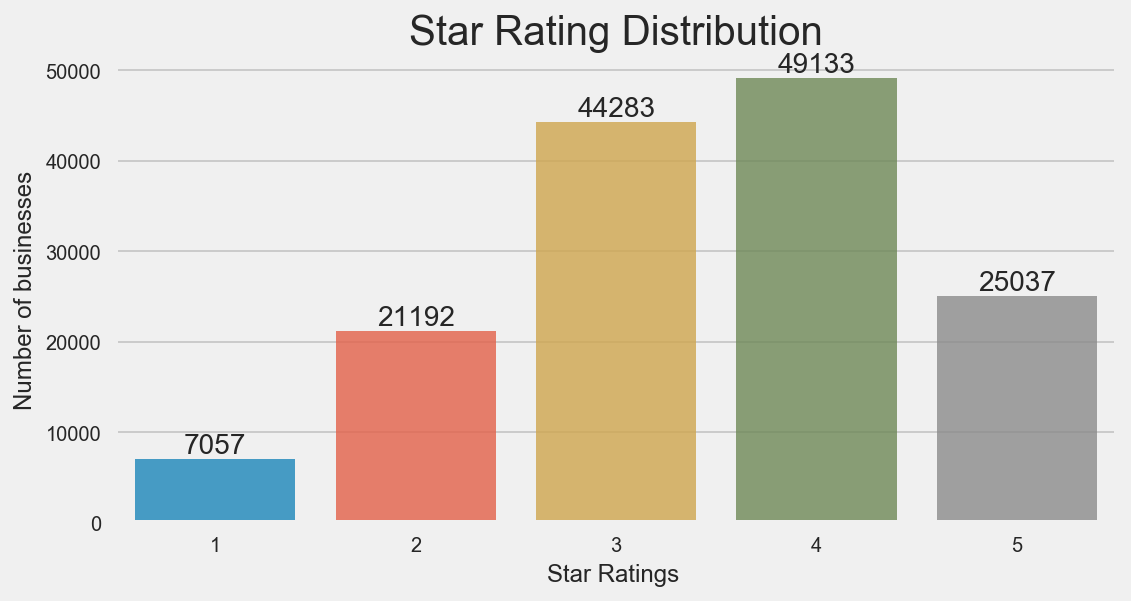

In [126]:
#Get the distribution of the ratings
x=all_business['stars'].value_counts()
x=x.sort_index()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('Number of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

#plt.show()
plt.savefig('stars.png', bbox_inches="tight", dpi=200)

In [47]:
plt.savefig('stars.png')

<Figure size 432x288 with 0 Axes>

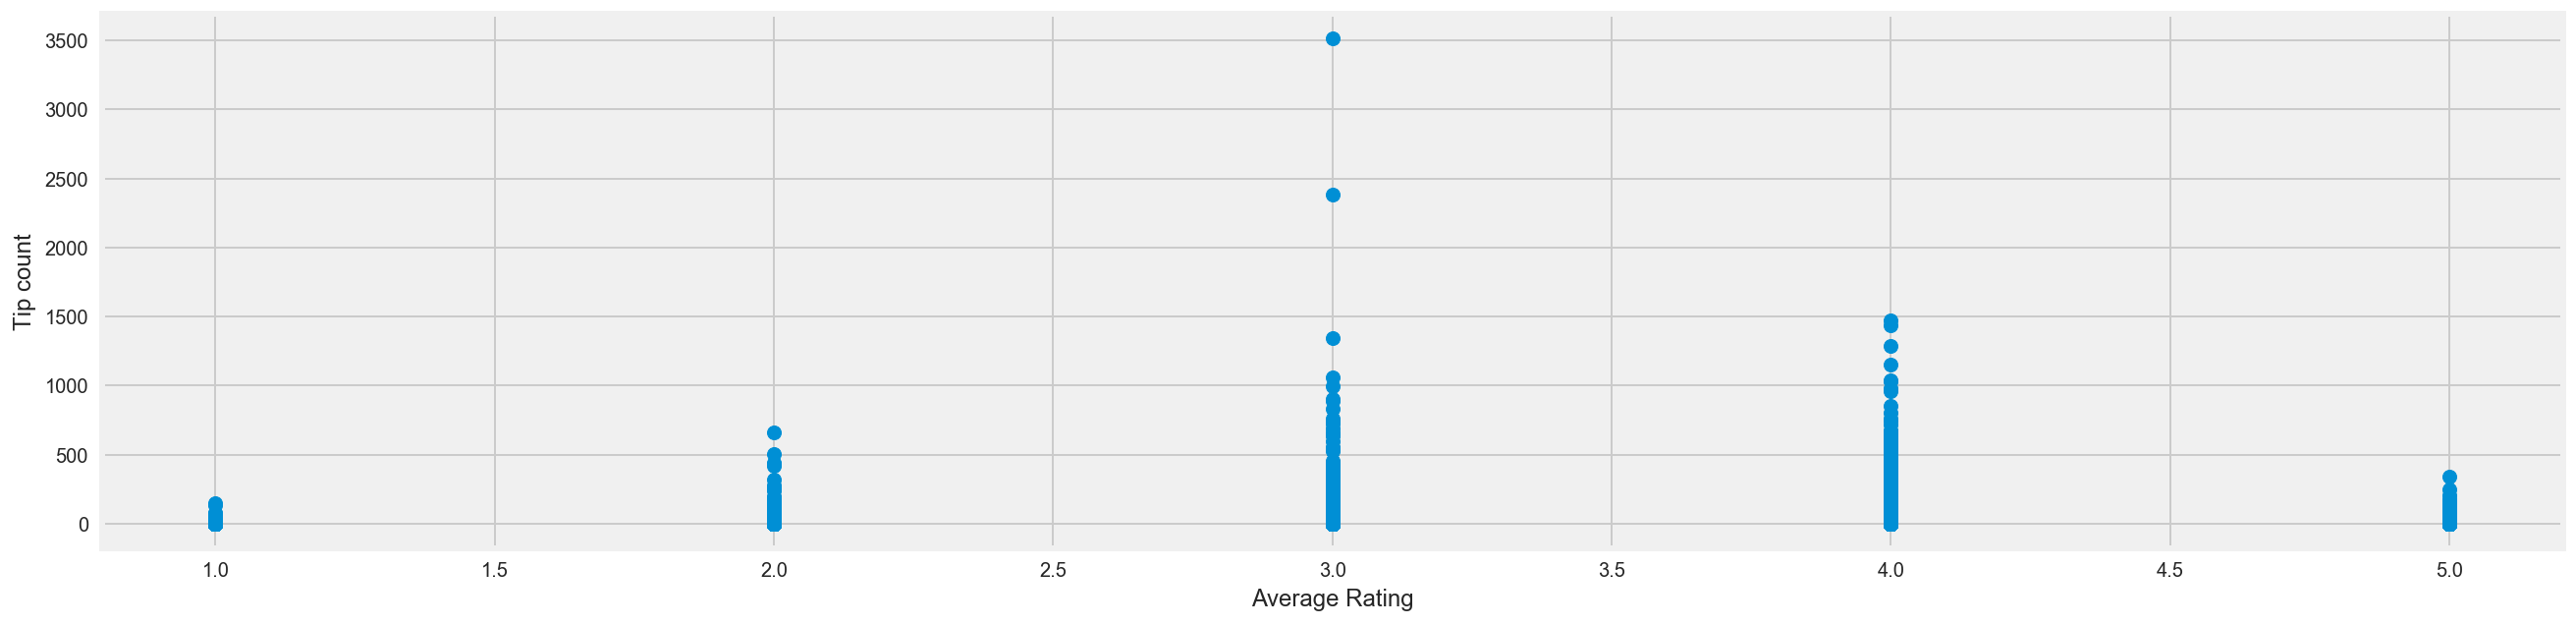

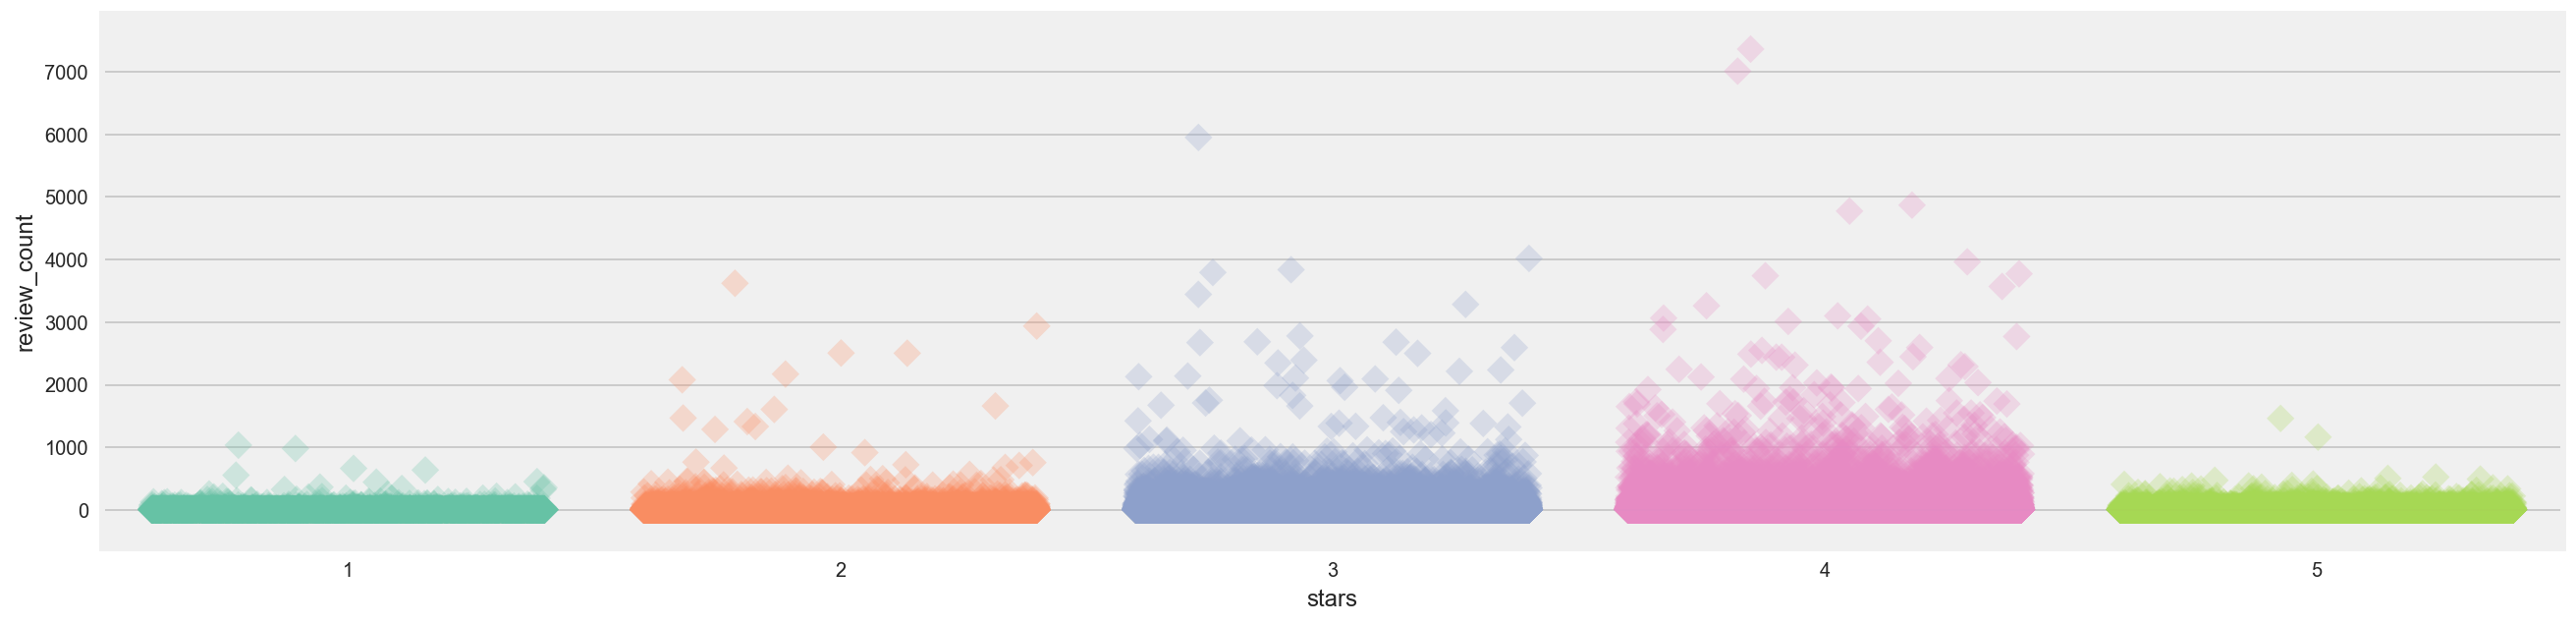

In [48]:
plt.figure(figsize=(20,5))
plt.scatter(all_business.stars, all_business.tip_count)
plt.xlabel("Average Rating")
plt.ylabel("Tip count")
plt.show()
plt.figure(figsize=(20,5))
ax =  sns.stripplot("stars", "review_count",data=all_business, palette="Set2", size=10, marker="D", edgecolor="gray", alpha=.25, jitter=.4)

plt.savefig('distri.png', bbox_inches="tight" , dpi=200)
#plt.savefig('distri.pdf', bbox_inches="tight" )

<a id="edacategory"></a>
## 3.2 Analysis on the different Categories
---
We can focus now on the various categories that are included in the dataset under column called 'categories'. All categories are merged into one cells for each business, so it would be interesting to explore all the categories available. Firstly, let see which business category is most popular.

In [49]:
# List all categories from the cells
category=pd.DataFrame(business_category.split(';'),columns=['category'])

There are 54602 different types/categories of Businesses in our Dataset!


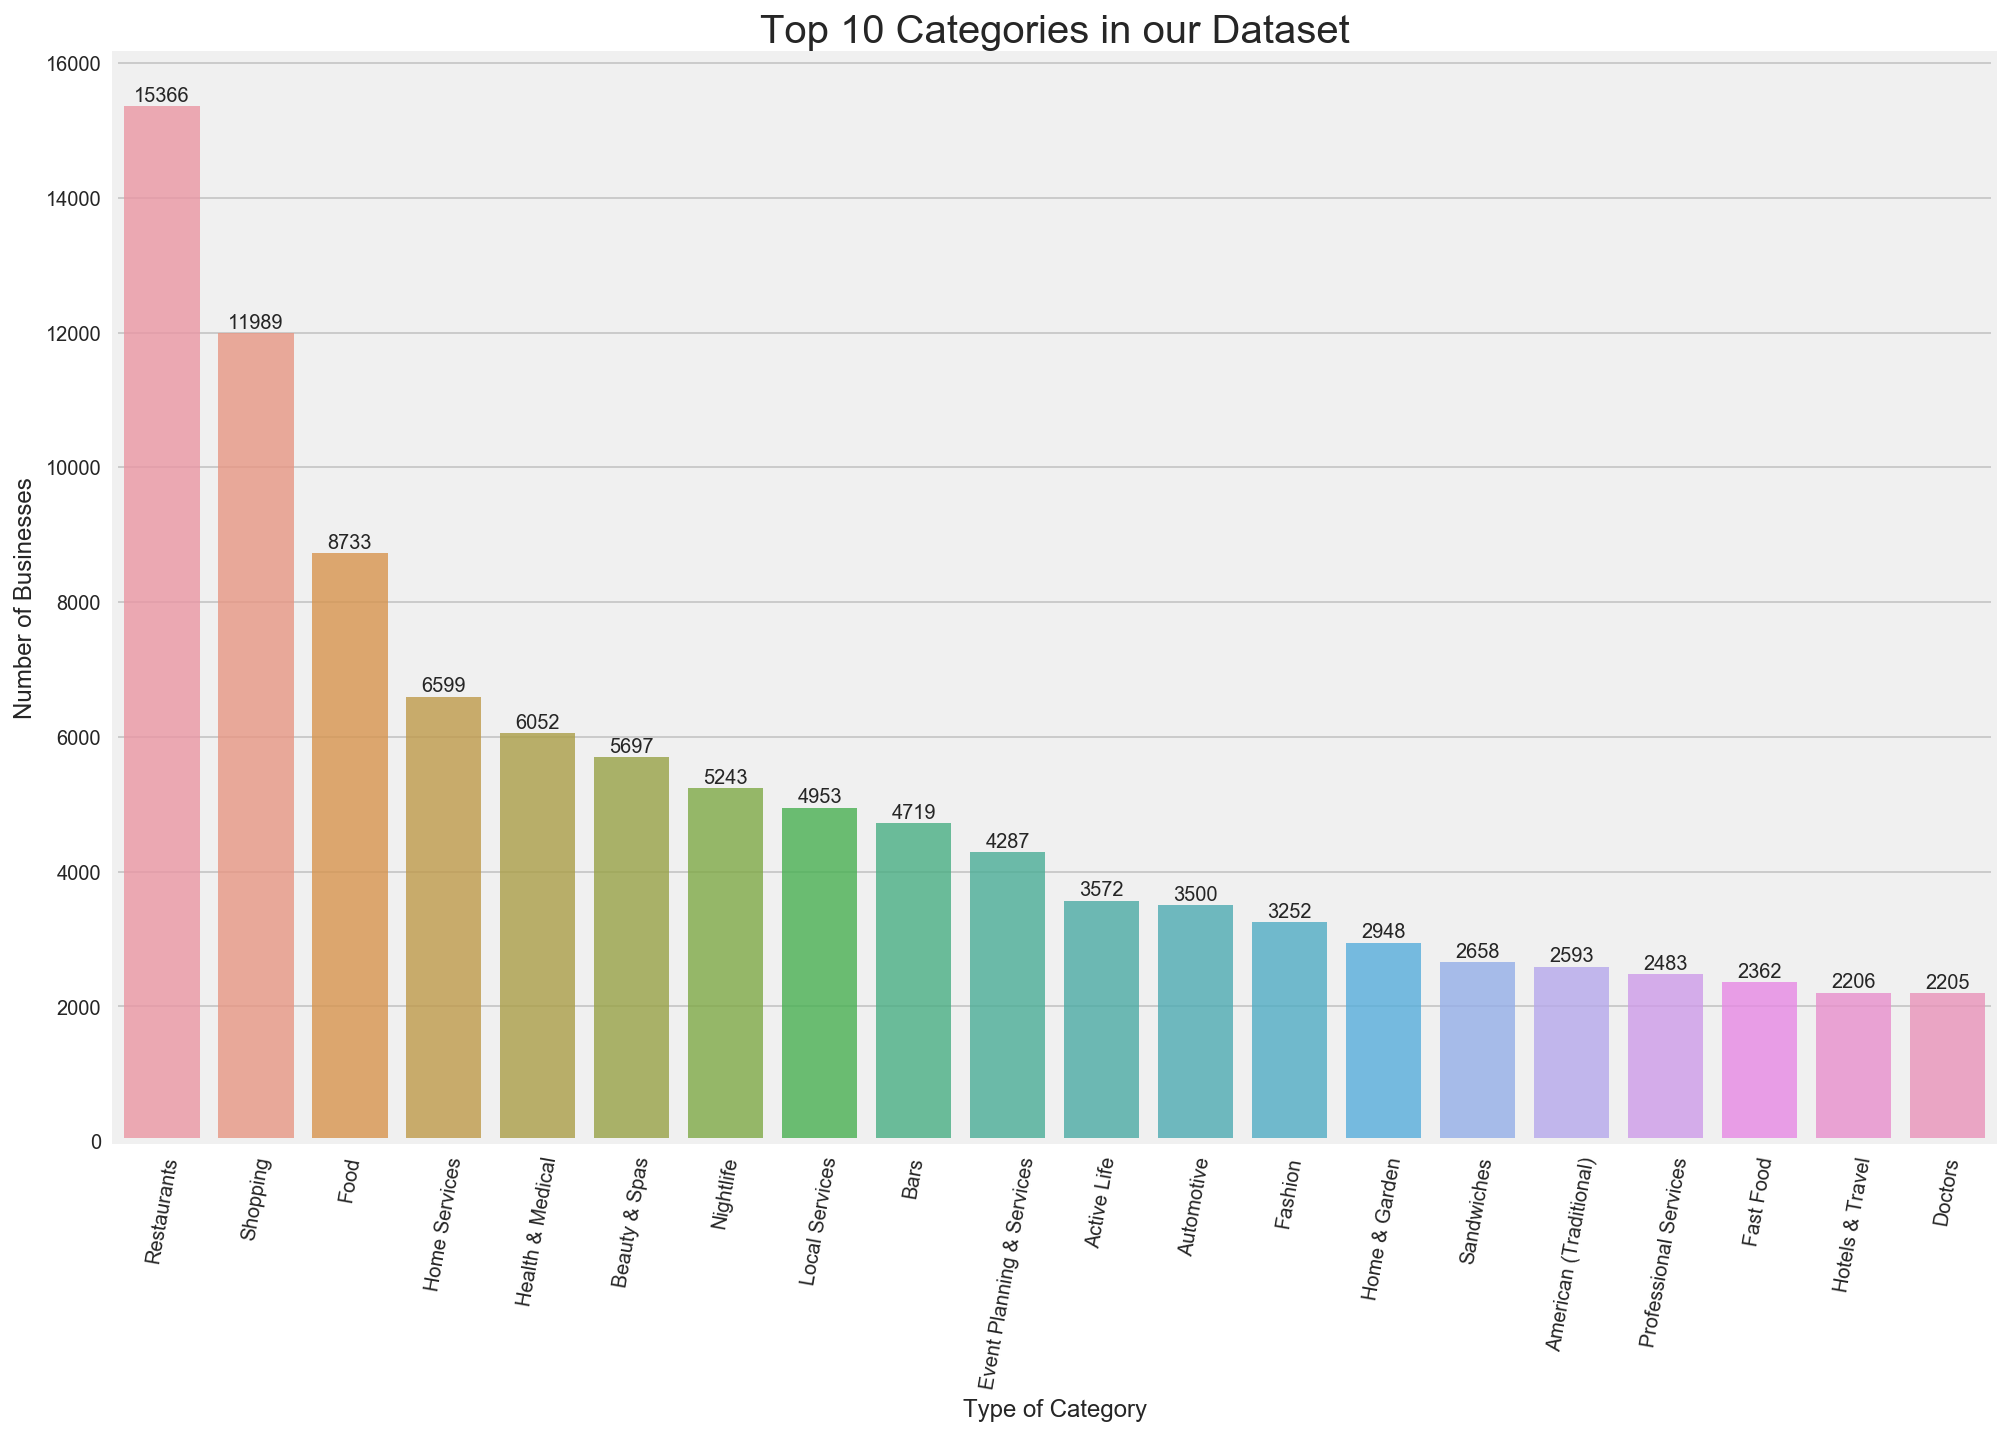

In [50]:
# What are the popular business categories?
x=category.category.value_counts()
print("There are", len(x),"different types/categories of Businesses in our Dataset!")
#prep for chart
x=x.sort_values(ascending=False)
x=x.iloc[0:20]

#chart to create
plt.figure(figsize=(15,10))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Top 10 Categories in our Dataset",fontsize=20)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('Number of Businesses', fontsize=12)
plt.xlabel('Type of Category', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, ha='center', va='bottom')

plt.savefig('categories.png', bbox_inches="tight" , dpi=200)

<a id="correlation"></a>
## 3.3 Correlation Analysis
---
Here, we are plotting the main correlation between each variables. We decided to select the variables that should be highly correlated with the target. Here we added the variables that we added to the main dataset. We can clearly see that the variable from the NPL are highly correlated, especially with negative reviews sentiment indicator. 


In [51]:
useful_variables = all_business.loc[:,["tip_count","weekendopen", "neg_tip", "neu_tip", 
                                       "pos_tip", "comp_tip", 'neg_review', 'neu_review', 'pos_review', 
                                      'comp_review', 'useful', 'funny', 'cool', 'ratings']]

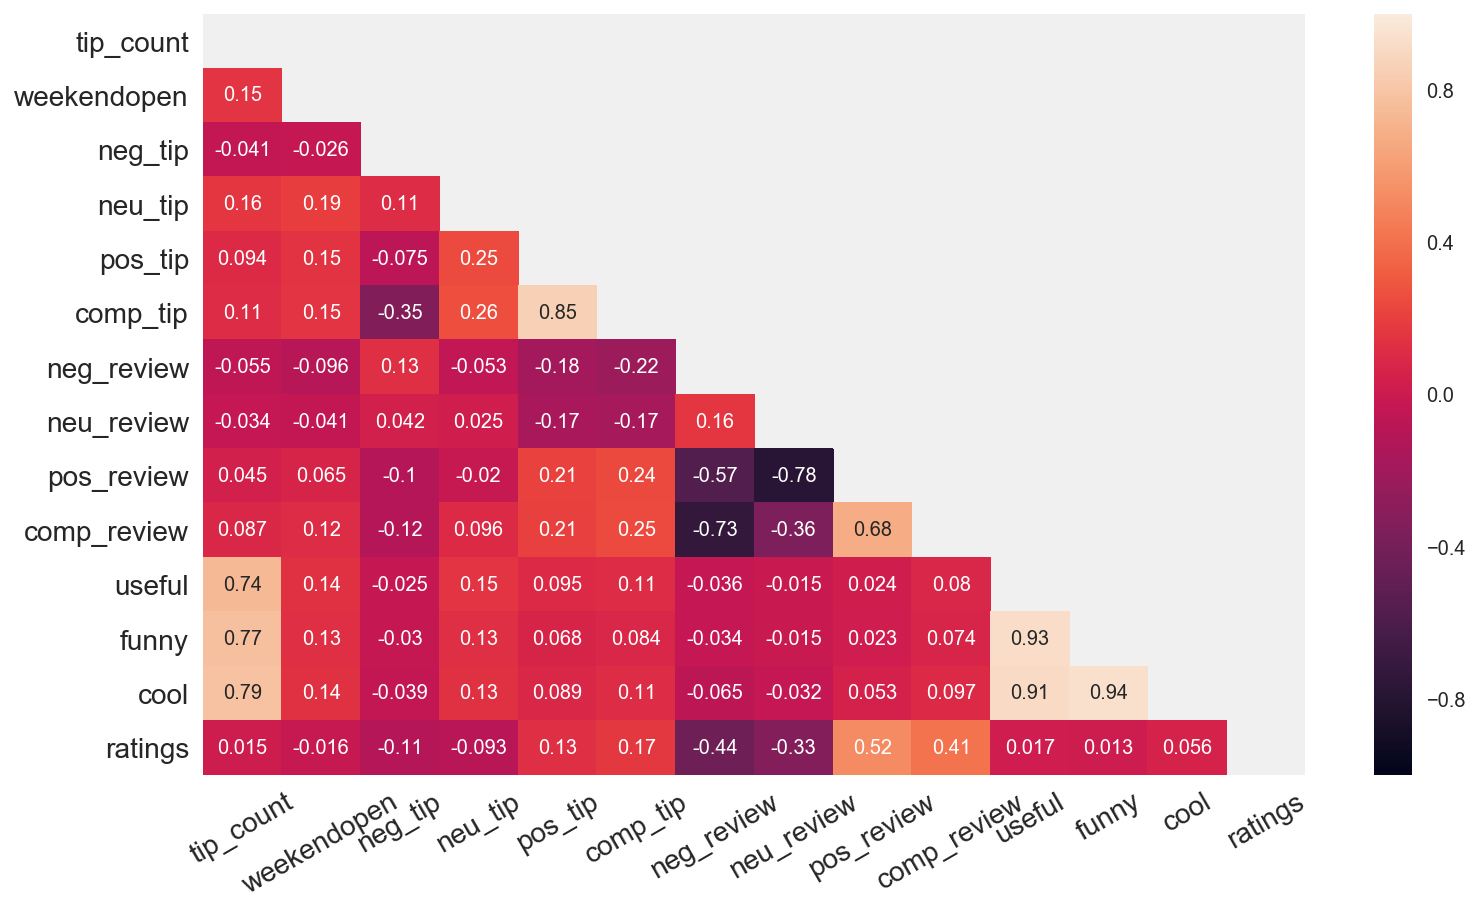

In [52]:

def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(11,7))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True, vmin=-1, vmax=1)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()


correlation_heat_map(useful_variables)

<a id="edastatistics"></a>
## 3.4 Summary Statistics
---
Let's have a look at the summary stats for all the variables. Here we can clearly see that most or our variables are boolean or integer values.

In [53]:
all_business.describe()

,latitude,longitude,stars,review_count,is_open,tip_count,weekendopen,categoriesautomotive,categoriescaterers,categoriesgeneral_dentistry,categoriesappliances,categoriespets,categoriesdesserts,categoriesspecialty_food,categorieswomen's_clothing,categoriesbanks_&_credit_unions,categoriesgyms,categoriespet_groomers,categorieshome_&_garden,categoriesflowers,categoriesdoctors,categoriesdepartment_stores,categoriesdrugstores,categoriesshoe_stores,categoriesarts_&_crafts,categoriespizza,categoriesmassage,categoriestires,categorieswine_&_spirits,categoriesauto_parts_&_supplies,categoriespet_services,categoriesburgers,categoriesitalian,categoriespet_sitting,categoriesspecialty_schools,categoriescanadian_(new),categoriesit_services_&_computer_repair,categoriesbreakfast_&_brunch,categoriesskin_care,categoriesnail_salons,categoriescoffee_&_tea,categoriesbakeries,categoriesmediterranean,categoriessushi_bars,categoriesapartments,categoriessteakhouses,categoriesamerican_(new),categoriesmassage_therapy,categoriessandwiches,categoriesoptometrists,categoriesgas_stations,categoriessporting_goods,categorieschiropractors,categoriesday_spas,categoriesconvenience_stores,categoriesnightlife,categorieshair_salons,categoriesparks,categoriescar_dealers,categoriesjewelry,categoriesjuice_bars_&_smoothies,categoriesasian_fusion,categoriescafes,categoriesbars,categorieslaundry_services,categoriesfood,categoriesfast_food,categoriesplumbing,categorieshotels,categoriesseafood,categoriesbarbeque,categoriesrestaurants,categoriespublic_services_&_government,categorieschinese,categorieswaxing,categoriesaccessories,categoriesbarbers,categoriescontractors,categoriesvenues_&_event_spaces,categoriesbeer,categorieslocal_services,categorieshair_removal,categoriesveterinarians,categoriesice_cream_&_frozen_yogurt,categoriesfashion,categoriescosmetics_&_beauty_supply,categorieshome_decor,categoriesgrocery,categoriesmexican,categoriesevent_planning_&_services,categoriessports_bars,categorieshealth_&_medical,categoriesreal_estate_services,categoriesheating_&_air_conditioning/hvac,categorieshotels_&_travel,categoriesactive_life,categoriesshopping,categoriesbeauty_&_spas,categoriesfitness_&_instruction,categoriesprofessional_services,categorieschicken_wings,categoriesarts_&_entertainment,categoriesflowers_&_gifts,categorieseyelash_service,categorieseducation,categoriessalad,categoriesdry_cleaning,categorieshair_stylists,categoriesparty_&_event_planning,categoriesdentists,categorieshome_services,categoriesfurniture_stores,categoriesna,categorieselectronics,categoriestrainers,categoriesfinancial_services,categoriesamerican_(traditional),categoriesreal_estate,categoriesjapanese,categoriesoil_change_stations,categoriescosmetic_dentists,categoriesdry_cleaning_&_laundry,categoriesdelis,categoriesauto_repair,categoriespubs,categoriesmedical_centers,categoriesmen's_clothing,neg_tip,neu_tip,pos_tip,comp_tip,neg_review,neu_review,pos_review,comp_review,useful,funny,cool,ratings,businessacceptscreditcards_false,businessacceptscreditcards_true,businessacceptscreditcards_nan,businessparking_garage_false,businessparking_garage_true,businessparking_garage_nan,businessparking_street_false,businessparking_street_true,businessparking_street_nan,businessparking_validated_false,businessparking_validated_true,businessparking_validated_nan,businessparking_lot_false,businessparking_lot_true,businessparking_lot_nan,businessparking_valet_false,businessparking_valet_true,businessparking_valet_nan,hairspecializesin_coloring_false,hairspecializesin_coloring_true,hairspecializesin_coloring_nan,wheelchairaccessible_false,wheelchairaccessible_true,wheelchairaccessible_nan,bikeparking_false,bikeparking_true,bikeparking_nan,alcohol_false,alcohol_true,alcohol_nan,happyhour_false,happyhour_true,happyhour_nan,dogsallowed_false,dogsallowed_true,dogsallowed_nan
count,146702.000000,146702.000000,146702.000000,146702.000000,146702.0,146702.000000,146702.000000,146702.000000,146702.000000,146702.000000,146702.000000,

<a id="models"></a>
# 4. Models
---
Now that we have conducted the EDA, we can test some models. We will first run all the main models available for classification and then choose 2 of the best model. As we can see the logistic and random forest are the best two model. We can then try to improve our model by using GridSearch and Lasso.

In [54]:
# delete stars as we have now ratings
all_business = all_business.drop('stars', axis=1)

In [55]:
#set the target
y = all_business['ratings']
# Change the target to interger
y = y.astype(np.int64)


#set the x.axis
all_business = all_business.drop('ratings', axis=1)
all_business = all_business.drop('business_id', axis=1)
X = all_business

In [56]:
# set train split for the entire dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(102691, 173) (102691,)
(44011, 173) (44011,)


In [57]:
# sample to test - will remove this
#all_business_sample = all_business.sample(100)
all_business.head(1)

,latitude,longitude,review_count,is_open,tip_count,weekendopen,categoriesautomotive,categoriescaterers,categoriesgeneral_dentistry,categoriesappliances,categoriespets,categoriesdesserts,categoriesspecialty_food,categorieswomen's_clothing,categoriesbanks_&_credit_unions,categoriesgyms,categoriespet_groomers,categorieshome_&_garden,categoriesflowers,categoriesdoctors,categoriesdepartment_stores,categoriesdrugstores,categoriesshoe_stores,categoriesarts_&_crafts,categoriespizza,categoriesmassage,categoriestires,categorieswine_&_spirits,categoriesauto_parts_&_supplies,categoriespet_services,categoriesburgers,categoriesitalian,categoriespet_sitting,categoriesspecialty_schools,categoriescanadian_(new),categoriesit_services_&_computer_repair,categoriesbreakfast_&_brunch,categoriesskin_care,categoriesnail_salons,categoriescoffee_&_tea,categoriesbakeries,categoriesmediterranean,categoriessushi_bars,categoriesapartments,categoriessteakhouses,categoriesamerican_(new),categoriesmassage_therapy,categoriessandwiches,categoriesoptometrists,categoriesgas_stations,categoriessporting_goods,categorieschiropractors,categoriesday_spas,categoriesconvenience_stores,categoriesnightlife,categorieshair_salons,categoriesparks,categoriescar_dealers,categoriesjewelry,categoriesjuice_bars_&_smoothies,categoriesasian_fusion,categoriescafes,categoriesbars,categorieslaundry_services,categoriesfood,categoriesfast_food,categoriesplumbing,categorieshotels,categoriesseafood,categoriesbarbeque,categoriesrestaurants,categoriespublic_services_&_government,categorieschinese,categorieswaxing,categoriesaccessories,categoriesbarbers,categoriescontractors,categoriesvenues_&_event_spaces,categoriesbeer,categorieslocal_services,categorieshair_removal,categoriesveterinarians,categoriesice_cream_&_frozen_yogurt,categoriesfashion,categoriescosmetics_&_beauty_supply,categorieshome_decor,categoriesgrocery,categoriesmexican,categoriesevent_planning_&_services,categoriessports_bars,categorieshealth_&_medical,categoriesreal_estate_services,categoriesheating_&_air_conditioning/hvac,categorieshotels_&_travel,categoriesactive_life,categoriesshopping,categoriesbeauty_&_spas,categoriesfitness_&_instruction,categoriesprofessional_services,categorieschicken_wings,categoriesarts_&_entertainment,categoriesflowers_&_gifts,categorieseyelash_service,categorieseducation,categoriessalad,categoriesdry_cleaning,categorieshair_stylists,categoriesparty_&_event_planning,categoriesdentists,categorieshome_services,categoriesfurniture_stores,categoriesna,categorieselectronics,categoriestrainers,categoriesfinancial_services,categoriesamerican_(traditional),categoriesreal_estate,categoriesjapanese,categoriesoil_change_stations,categoriescosmetic_dentists,categoriesdry_cleaning_&_laundry,categoriesdelis,categoriesauto_repair,categoriespubs,categoriesmedical_centers,categoriesmen's_clothing,neg_tip,neu_tip,pos_tip,comp_tip,neg_review,neu_review,pos_review,comp_review,useful,funny,cool,businessacceptscreditcards_false,businessacceptscreditcards_true,businessacceptscreditcards_nan,businessparking_garage_false,businessparking_garage_true,businessparking_garage_nan,businessparking_street_false,businessparking_street_true,businessparking_street_nan,businessparking_validated_false,businessparking_validated_true,businessparking_validated_nan,businessparking_lot_false,businessparking_lot_true,businessparking_lot_nan,businessparking_valet_false,businessparking_valet_true,businessparking_valet_nan,hairspecializesin_coloring_false,hairspecializesin_coloring_true,hairspecializesin_coloring_nan,wheelchairaccessible_false,wheelchairaccessible_true,wheelchairaccessible_nan,bikeparking_false,bikeparking_true,bikeparking_nan,alcohol_false,alcohol_true,alcohol_nan,happyhour_false,happyhour_true,happyhour_nan,dogsallowed_false,dogsallowed_true,dogsallowed_nan
0,33.33069,-111.978599,22,1,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [58]:
# Baseline of our dataset
baseline = np.mean(y_train)
baseline_pred = np.empty(len(y_train))
baseline_pred.fill(baseline)
print("Baseline Mean:", baseline)
#print ("Baseline RMSE:", np.sqrt(mean_squared_error(y, baseline_pred)))

Baseline Mean: 0.5046596098976541


<a id="classic_models"></a>
## 4.1 All Classic Models
---
As we know a linear regression will not be the best here, as we have values between 1 to 5 as targer, so we will be using classification models. Below the model that we will be using:
- Logistic Regression
- KNN
- Decision Tree
- Random Forest

In [59]:
# standatized it
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xs = scaler.fit_transform(X_train)

In [60]:
X.head()

,latitude,longitude,review_count,is_open,tip_count,weekendopen,categoriesautomotive,categoriescaterers,categoriesgeneral_dentistry,categoriesappliances,categoriespets,categoriesdesserts,categoriesspecialty_food,categorieswomen's_clothing,categoriesbanks_&_credit_unions,categoriesgyms,categoriespet_groomers,categorieshome_&_garden,categoriesflowers,categoriesdoctors,categoriesdepartment_stores,categoriesdrugstores,categoriesshoe_stores,categoriesarts_&_crafts,categoriespizza,categoriesmassage,categoriestires,categorieswine_&_spirits,categoriesauto_parts_&_supplies,categoriespet_services,categoriesburgers,categoriesitalian,categoriespet_sitting,categoriesspecialty_schools,categoriescanadian_(new),categoriesit_services_&_computer_repair,categoriesbreakfast_&_brunch,categoriesskin_care,categoriesnail_salons,categoriescoffee_&_tea,categoriesbakeries,categoriesmediterranean,categoriessushi_bars,categoriesapartments,categoriessteakhouses,categoriesamerican_(new),categoriesmassage_therapy,categoriessandwiches,categoriesoptometrists,categoriesgas_stations,categoriessporting_goods,categorieschiropractors,categoriesday_spas,categoriesconvenience_stores,categoriesnightlife,categorieshair_salons,categoriesparks,categoriescar_dealers,categoriesjewelry,categoriesjuice_bars_&_smoothies,categoriesasian_fusion,categoriescafes,categoriesbars,categorieslaundry_services,categoriesfood,categoriesfast_food,categoriesplumbing,categorieshotels,categoriesseafood,categoriesbarbeque,categoriesrestaurants,categoriespublic_services_&_government,categorieschinese,categorieswaxing,categoriesaccessories,categoriesbarbers,categoriescontractors,categoriesvenues_&_event_spaces,categoriesbeer,categorieslocal_services,categorieshair_removal,categoriesveterinarians,categoriesice_cream_&_frozen_yogurt,categoriesfashion,categoriescosmetics_&_beauty_supply,categorieshome_decor,categoriesgrocery,categoriesmexican,categoriesevent_planning_&_services,categoriessports_bars,categorieshealth_&_medical,categoriesreal_estate_services,categoriesheating_&_air_conditioning/hvac,categorieshotels_&_travel,categoriesactive_life,categoriesshopping,categoriesbeauty_&_spas,categoriesfitness_&_instruction,categoriesprofessional_services,categorieschicken_wings,categoriesarts_&_entertainment,categoriesflowers_&_gifts,categorieseyelash_service,categorieseducation,categoriessalad,categoriesdry_cleaning,categorieshair_stylists,categoriesparty_&_event_planning,categoriesdentists,categorieshome_services,categoriesfurniture_stores,categoriesna,categorieselectronics,categoriestrainers,categoriesfinancial_services,categoriesamerican_(traditional),categoriesreal_estate,categoriesjapanese,categoriesoil_change_stations,categoriescosmetic_dentists,categoriesdry_cleaning_&_laundry,categoriesdelis,categoriesauto_repair,categoriespubs,categoriesmedical_centers,categoriesmen's_clothing,neg_tip,neu_tip,pos_tip,comp_tip,neg_review,neu_review,pos_review,comp_review,useful,funny,cool,businessacceptscreditcards_false,businessacceptscreditcards_true,businessacceptscreditcards_nan,businessparking_garage_false,businessparking_garage_true,businessparking_garage_nan,businessparking_street_false,businessparking_street_true,businessparking_street_nan,businessparking_validated_false,businessparking_validated_true,businessparking_validated_nan,businessparking_lot_false,businessparking_lot_true,businessparking_lot_nan,businessparking_valet_false,businessparking_valet_true,businessparking_valet_nan,hairspecializesin_coloring_false,hairspecializesin_coloring_true,hairspecializesin_coloring_nan,wheelchairaccessible_false,wheelchairaccessible_true,wheelchairaccessible_nan,bikeparking_false,bikeparking_true,bikeparking_nan,alcohol_false,alcohol_true,alcohol_nan,happyhour_false,happyhour_true,happyhour_nan,dogsallowed_false,dogsallowed_true,dogsallowed_nan
0,33.330690,-111.978599,22,1,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [61]:
# test all the classic model and choose the one that produce to best accuracy

In [62]:
#get all the score into an araay
Accuracy_Scores =[]
Accuracy_Scores.append(['Baseline', baseline])

In [63]:
# logistic regression
def classiclogistic(X, y, cv_folds=3):
    '''
    ===========================
    Classic Logistic Regression
    ===========================
    INPUTS
    ------
    * X = features
    * y = target
    * cv_folds = number of cross validation folds to use
    '''
    logistic = LogisticRegression()
    scores = cross_val_score(logistic, X, y, cv = cv_folds, verbose=1)
    print (scores)
    print (np.mean(scores))
    Accuracy_Scores.append(['Classic Reg',np.mean(scores)])

In [64]:
classiclogistic(X_train, y_train, 3)

[0.80333616 0.79930472 0.80084139]
0.801160757624995


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.7s finished


In [65]:
# KNN
def classicKNN(X, y, cv_folds=3):
    '''
    ===========
    Classic KNN
    ===========
    INPUTS
    ------
    * X = features
    * y = target
    * cv_folds = number of cross validation folds to use
    '''
    model = KNeighborsClassifier(n_neighbors=5, weights='uniform')
    # Fit the model
    model.fit(X, y)

    # Predict
    #print( model.predict(X))
    
    scores = cross_val_score(model, X, y, cv = cv_folds, verbose=1)
    print (scores)
    print (np.mean(scores))
    Accuracy_Scores.append(['Classic KNN',np.mean(scores)])

In [66]:
classicKNN(X_train, y_train, 3)

[0.66024948 0.66089217 0.65722049]
0.6594540469259941


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min finished


In [67]:
# Decision Tree
def classicDecisionTree(X, y, cv_folds=3):
    '''
    =====================
    Classic Decision Tree
    =====================
    INPUTS
    ------
    * X = features
    * y = target
    * cv_folds = number of cross validation folds to use
    '''
    
    model = DecisionTreeClassifier(max_depth=2)
    # Fits the model
    model.fit(X, y)
     
    scores = cross_val_score(model, X, y, scoring='accuracy', cv= cv_folds, verbose=1)
        
    print (scores)
    print (np.mean(scores))
    Accuracy_Scores.append(['Classic Decision Tree',np.mean(scores)])

In [68]:
classicDecisionTree(X_train,y_train,3)

[0.75992521 0.75563086 0.7540974 ]
0.7565511592299922


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished


In [69]:
# Random Forest
def classicRandomForest(X, y, cv_folds=3):
    '''
    =====================
    Classic Random Forest
    =====================
    INPUTS
    ------
    * X = features
    * y = target
    * cv_folds = number of cross validation folds to use
    '''
    
    model = RandomForestClassifier(n_estimators = 20)
    
    model.fit(X, y)
     
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv_folds, verbose=1)
    
    print (scores)
    print (np.mean(scores))
    Accuracy_Scores.append(['Classic Random Forest',np.mean(scores)])

In [70]:
classicRandomForest(X_train,y_train, 3)

[0.81309339 0.80806871 0.81054077]
0.8105676246826858


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.4s finished


In [71]:
# Print out the results
all_results = pd.DataFrame(Accuracy_Scores, columns=('Models', 'Accuracy Scores'))
all_results

,Models,Accuracy Scores
0,Baseline,0.504660
1,Classic Reg,0.801161
2,Classic KNN,0.659454
3,Classic Decision Tree,0.756551
4,Classic Random Forest,0.810568


<a id="complex_models"></a>
## 4.2 Complex Models with Lasso & GridSearch
---
We can now clearly see that the logistic and Random forest predict the most accurately our business ratings. We will therefore use Lasso and GridSearch to get best parameters. We use Lasso and not Ridge here, as we have many variables.

In [72]:
# logistic regression and lasso
def logistic(X, y, cv_folds=3):
    '''
    ==========================================
    Logistic Regression With Lasso, GridSearch
    ==========================================
    INPUTS
    ------
    * X = features
    * y = target
    * cv_folds = number of cross validation folds to use
    '''
    # l1 is Lasso, l2 is ridge. NB: lowercase letter 'ell' "l"
    logistic = LogisticRegression(penalty='l1')
    
    # specify search parameters
    search_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         "fit_intercept": [True, False],
                         "intercept_scaling": [0.2575]} # best estimator tested

    # set up grid search
    estimator = GridSearchCV(logistic, search_parameters, cv = cv_folds, scoring='accuracy' , verbose=1)
    # "fit" the model
    results = estimator.fit(X, y)
    # Present Results
    print("Best estimator:")
    print(results.best_estimator_)
    print()
    print("Best score:")
    print(results.best_score_)
    print()
    print("Best params:")
    print(results.best_params_)
    print()
    
    Accuracy_Scores.append(['Complex Logistic Regression',results.best_score_])

In [73]:
logistic(X_train,y_train, 3)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:  6.4min finished


Best estimator:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=0.2575, max_iter=100, multi_class='ovr',
          n_jobs=1, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Best score:
0.8025825047959412

Best params:
{'C': 0.1, 'fit_intercept': True, 'intercept_scaling': 0.2575}



In [74]:
# random forest and lasso
def randomForest(X, y, cv_folds=3):
    '''
    ====================================================
    Classic Random Forest with Parameters and GridSearch
    ====================================================
    INPUTS
    ------
    * X = features
    * y = target
    * cv_folds = number of cross validation folds to use
    '''
    rf = RandomForestClassifier()
    search_parameters = {
        "max_depth": range(1,50),
        "min_samples_split": [20],
        "n_estimators" : [20],}

    # set up grid search
    estimator = GridSearchCV(rf, search_parameters, cv = cv_folds, scoring='accuracy' , verbose=1)
    # "fit" the model
    results = estimator.fit(X, y)
    # Present Results
    print("Best estimator:")
    print(results.best_estimator_)
    print()
    print("Best score:")
    print(results.best_score_)
    print()
    print("Best params:")
    print(results.best_params_)
    print()
    
    Accuracy_Scores.append(['Complex Random Forest',results.best_score_])

In [75]:
randomForest(X_train,y_train, 2)

Fitting 2 folds for each of 49 candidates, totalling 98 fits


[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:  3.9min finished


Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=28, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Best score:
0.8156605739548743

Best params:
{'max_depth': 28, 'min_samples_split': 20, 'n_estimators': 20}



In [76]:
all_results = pd.DataFrame(Accuracy_Scores, columns=('Models', 'Accuracy Scores'))
all_results

,Models,Accuracy Scores
0,Baseline,0.504660
1,Classic Reg,0.801161
2,Classic KNN,0.659454
3,Classic Decision Tree,0.756551
4,Classic Random Forest,0.810568
5,Complex Logistic Regression,0.802583
6,Complex Random Forest,0.815661


<a id="predictions"></a>
## 4.3 Predictions with the Best Model
---
Let's now test the model with y_test and X_test to see if our model predict the business rating also in the test part.

In [77]:
# best model
logistic = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

logistic.fit(X_train, y_train)
predictions = logistic.predict(X_test)

scores = cross_val_score(logistic, X_test, y_test, cv = 3, verbose=1)

print (scores)
print (np.mean(scores))

[0.80962443 0.80144503 0.79998637]
0.8036852741856181


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.1s finished


<a id="conclusions"></a>
# 5. Conclusions
---
- We improved our prediction from 0.6 to 0.8 by adding the NLP into our model. This has a strong influence in our model. We can also see that the accuracy of 0.8 is quiet a good improvement compare to our baseline of 0.5.
- The logistic and Random Forest are the best model here in predicting the ratings of a business in the yelp dataset. 
- By using the train split, we can see that the result is fairly similar, around 0.8, which proves that the model is solid accross the entire dataset.
- Would be interesting to product a graph with either the confusion matrix of the area under the curve to see our predictions compare to the actual value.
- We can see that by using GridSearch and Lasso didn't really improve our model, all of them are around 80% accuracy.

In [78]:
# best model
logistic = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=28, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


logistic.fit(X_train, y_train)
predictions = logistic.predict(X_test)

scores = cross_val_score(logistic, X_test, y_test, cv = 3, verbose=1 , scoring = 'accuracy')
features = X_test.columns
feature_importances = logistic.feature_importances_
features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

print (scores)
print (np.mean(scores))

[0.81609979 0.813237   0.81123458]
0.8135237877252773


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.5s finished


In [127]:
# confusion matrix
confusion_matrix(y_test, predictions)

array([[17271,  4394],
       [ 3554, 18792]])

Confusion matrix, without normalization
[[17271  4394]
 [ 3554 18792]]
Normalized confusion matrix
[[0.8  0.2 ]
 [0.16 0.84]]


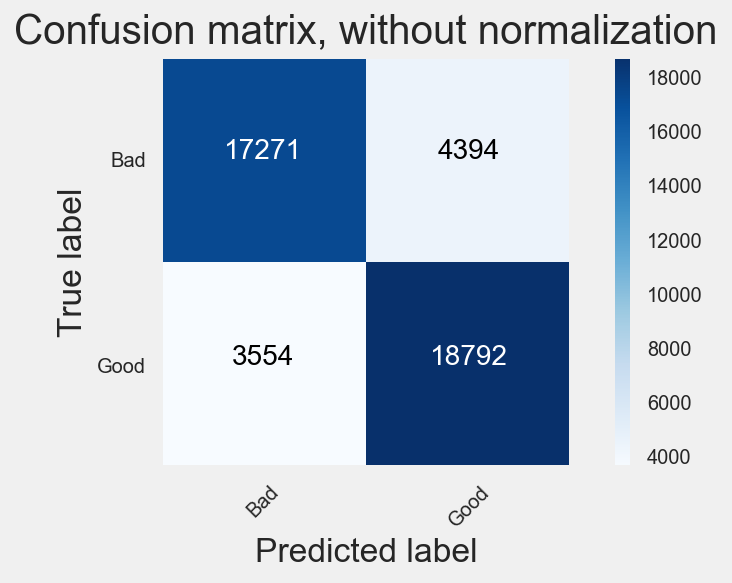

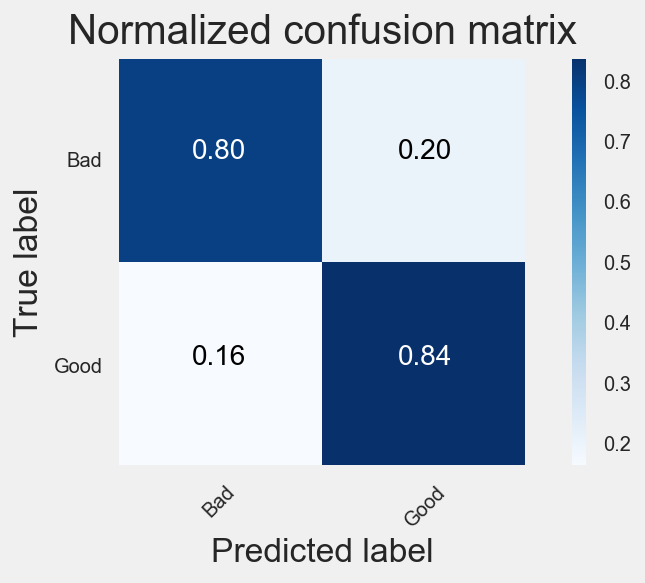

In [129]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Bad','Good'], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, classes=['Bad','Good'],
                      title='Normalized confusion matrix')

plt.savefig('confusion_1.png', bbox_inches="tight" ,transparent=True, dpi=200)